In [3]:
%matplotlib inline

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import menpo.io as mio
from menpo.math import log_gabor
from menpo.feature import greyscale, centralize, normalize_norm, normalize_std
from menpo.image import Image
from menpo.visualize import print_dynamic, progress_bar_str, visualize_images
from menpofit.visualize import visualize_fitting_results
from alaborticcv2015.alignment import (
    LKFitter, 
    FilteredSSD, FilteredFourierSSD, ECC, GradientImages, GradientCorrelation)
from alaborticcv2015.alignment.result import SerializableResult
from alaborticcv2015.deepconvkernel.loggabor import LogGaborLDCN

# Experiment 2: YaleB Database, LogGaborNet

In [4]:
db = mio.import_pickle('/Users/joan/Desktop/alaborticcv2015/data/yaleb.pkl.gz')

In [5]:
folder_path = '/Users/joan/Desktop/alaborticcv2015/results/yaleb/'

diagonal = None
scales = (1,)
max_iters = 100

n_rep = 5
noise_std = [16]

## LogGabor Net

In [6]:
net = LogGaborLDCN(n_layers=2, 
                   architecture=3, 
                   normalize_filters=None, 
                   patch_shape=(7, 7))
net.build_network(n_channels=1)

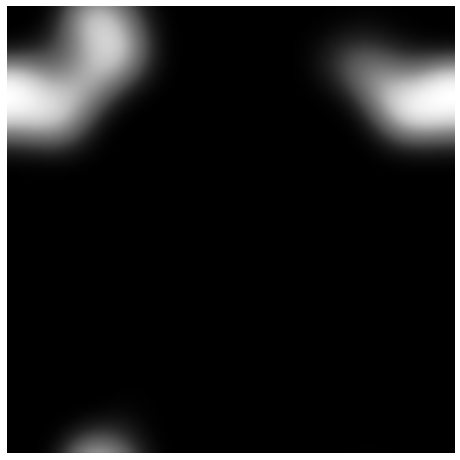

In [7]:
Image(np.real(kernel_func((100, 100)))).view()

In [8]:
def kernel_func(shape):
    return net._compute_kernel(ext_shape=shape)

errors = np.empty((len(noise_std), len(db), len(db[0]['images']), n_rep, max_iters+1))
for l, n in enumerate(noise_std):
    string = '- noise: {}, '.format(n)
    
    for sub in range(len(db)):
        string1 = string + ' sub: {}, '.format(sub)

        subject = db[sub]
        template = subject['template']
        test_images = subject['images']
        
        fitter = LKFitter(template,
                          group='bounding_box',
                          diagonal=diagonal,
                          scales=scales,
                          residual_cls=FilteredFourierSSD,
                          kernel_func=kernel_func)

        np.random.seed(0)
        for j, i in enumerate(test_images):
            string2 = string1 + ' img: {}, '.format(j)
            
            for k in range(n_rep):
                gt_s = i.landmarks['bounding_box'].lms
                s = fitter.perturb_shape(gt_s, noise_std=n)
                fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)
                fr.downscale = 0.5
                errors[l, sub, j, k] = fr.errors()
                
            
            ini_errors = errors[l, sub, j, :, 0]
            ini_mean = np.mean(ini_errors)
            ini_median = np.median(ini_errors)
            ini_std = np.std(ini_errors)
            
            final_errors = errors[l, sub, j, :, -1]
            final_mean = np.mean(final_errors)
            final_median = np.median(final_errors)
            final_std = np.std(final_errors)
            
            print_dynamic(string2 + 
                          ' mean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) + 
                          ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) + 
                          ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std)) 

        ini_errors = errors[l, sub, :, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)

        final_errors = errors[l, sub, :, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)

        print_dynamic(string2 + 
                      ' mean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) + 
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) + 
                      ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))
        
# mio.export_pickle(errors, 
#                   folder_path + 'yaleb_pcanet_' + pcanet_params + '.pkl.gz', 
#                   overwrite=True)

- noise: 16,  sub: 0,  img: 3,  mean: 0.1136 - 1.4639  median: 0.1113 - 1.5634  std: 0.0346 - 0.2612 

KeyboardInterrupt: 

In [ ]:
visualize_fitting_results(fr)